## Frequency-domain decomposition

In [ ]:
import numpy as np

def lowpass_fft(W, cutoff_frac=0.1, taper_width=0.02, pad=True):
    """
    Low-pass filter weight matrix W (T x N) via FFT on time axis (axis=0), vectorized.
    cutoff_frac: fraction of Nyquist (0..0.5). e.g. 0.1 -> keep <10% of Nyquist. (smaller cutoff -> smoother -> lower turnover.)
    taper_width: smooth taper region width (fraction of nyquist) for a cosine taper.
    pad: whether to reflect-pad time series to reduce edge artifacts.
    Returns W_smooth (T x N)
    """
    T, N = W.shape
    orig_T = T
    if pad:
        # reflect pad half-length
        pad_len = min(T,  max(10, int(0.1*T)))
        Wp = np.vstack([W[pad_len:0:-1], W, W[-2:-pad_len-2:-1]])  # reflect
    else:
        Wp = W.copy()
    Tp = Wp.shape[0]

    # FFT along time
    freqs = np.fft.rfftfreq(Tp)  # normalized to sampling freq = 1
    Wf = np.fft.rfft(Wp, axis=0)

    # build taper gain g(freq)
    nyq = 0.5
    cutoff = cutoff_frac * nyq / nyq  # simply cutoff_frac of Nyquist if freqs normalized; but rfftfreq in [0,0.5]
    # cutoff_frac refers to fraction of Nyquist; map to absolute freq in [0,0.5]
    cutoff_abs = cutoff_frac * 0.5
    # taper region
    taper = taper_width * 0.5
    g = np.zeros_like(freqs)
    low = max(0.0, cutoff_abs - taper)
    high = min(0.5, cutoff_abs + taper)
    for i, f in enumerate(freqs):
        if f <= low:
            g[i] = 1.0
        elif f >= high:
            g[i] = 0.0
        else:
            # cosine taper
            x = (f - low) / (high - low)
            g[i] = 0.5*(1 + np.cos(np.pi*(2*x - 1)))  # smooth from 1 -> 0

    # apply gain
    Wf *= g[:, None]

    # inverse FFT
    Wp_smooth = np.fft.irfft(Wf, n=Tp, axis=0)

    # unpad
    if pad:
        W_smooth = Wp_smooth[pad_len:pad_len+orig_T]
    else:
        W_smooth = Wp_smooth[:orig_T]

    # numerical cleanup
    W_smooth = np.real(W_smooth)
    return W_smooth

# Example usage:
# W_smooth = lowpass_fft(W, cutoff_frac=0.05, taper_width=0.01)

def project_dollar_neutral_and_l1(W, l1_target=1.0):
    # W: T x N
    Wp = W - W.mean(axis=1, keepdims=True)
    # renormalize L1 to l1_target (if rows are all zeros skip)
    row_l1 = np.sum(np.abs(Wp), axis=1, keepdims=True)
    safe = row_l1.squeeze() > 1e-12
    Wp[safe] = Wp[safe] * (l1_target / row_l1[safe])
    return Wp


## PCA + Kalman smoother on factor time-series

In [ ]:
import numpy as np

def compute_pca_factors(W, k):
    # W: T x N
    T, N = W.shape
    # center columns? Usually center rows (daily mean) to maintain dollar-neutrality across assets later.
    # Here we'll do SVD on W directly (optionally subtract row means)
    U, s, Vt = np.linalg.svd(W, full_matrices=False)
    # U: T x r, s: r, Vt: r x N
    U_k = U[:, :k]
    s_k = s[:k]
    Vt_k = Vt[:k, :]
    A = U_k * s_k[None, :]          # T x k  (factor time series)
    L = Vt_k.T                      # N x k  (loadings)
    return A, L

def kalman_smoother(F, Q, H, R, Y, x0=None, P0=None):
    """
    RTS Kalman smoother for multivariate time series.
    Y: T x k_obs  (observations per time)
    F: state transition (k x k)
    Q: process noise (k x k)
    H: observation matrix (k_obs x k)
    R: obs noise (k_obs x k_obs)
    Returns X_smooth: T x k (smoothed states)
    """
    T, kobs = Y.shape
    k = F.shape[0]
    if x0 is None:
        x0 = np.zeros(k)
    if P0 is None:
        P0 = np.eye(k) * 1e-6

    # allocate
    x_pred = np.zeros((T, k))
    P_pred = np.zeros((T, k, k))
    x_filt = np.zeros((T, k))
    P_filt = np.zeros((T, k, k))

    # initial
    x_prev = x0.copy()
    P_prev = P0.copy()

    # forward pass (filter)
    for t in range(T):
        # predict
        x_pr = F @ x_prev
        P_pr = F @ P_prev @ F.T + Q

        # innovation
        y = Y[t]
        S = H @ P_pr @ H.T + R
        # robust inversion
        K = P_pr @ H.T @ np.linalg.inv(S)

        innov = y - (H @ x_pr)
        x_upd = x_pr + K @ innov
        P_upd = (np.eye(k) - K @ H) @ P_pr

        x_pred[t] = x_pr
        P_pred[t] = P_pr
        x_filt[t] = x_upd
        P_filt[t] = P_upd

        x_prev = x_upd
        P_prev = P_upd

    # backward pass (RTS smoother)
    Xs = np.zeros_like(x_filt)
    Ps = np.zeros_like(P_filt)
    Xs[-1] = x_filt[-1]
    Ps[-1] = P_filt[-1]
    for t in range(T-2, -1, -1):
        P_pr_next = P_pred[t+1]
        J = P_filt[t] @ F.T @ np.linalg.inv(P_pr_next)
        Xs[t] = x_filt[t] + J @ (Xs[t+1] - x_pred[t+1])
        Ps[t] = P_filt[t] + J @ (Ps[t+1] - P_pr_next) @ J.T

    return Xs, Ps

def kalman_smooth_on_pca(W, k=5, proc_var=1e-4, obs_var=1e-2):
    """
    W: T x N weight matrix
    k: number of factors
    proc_var: process noise scale (Q = proc_var * I)
    obs_var: observation noise scale (R = obs_var * I)
    """
    A, L = compute_pca_factors(W, k)  # A: T x k, L: N x k
    T, kk = A.shape
    # Observations Y are the PCA factor time-series A (T x k)
    Y = A.copy()

    # State model: x_t = I x_{t-1} + eta, y_t = I x_t + eps
    F = np.eye(kk)
    H = np.eye(kk)
    Q = np.eye(kk) * proc_var
    R = np.eye(kk) * obs_var

    # initial state: use first observation
    x0 = Y[0].copy()
    P0 = np.eye(kk) * 1.0

    Xs, Ps = kalman_smoother(F, Q, H, R, Y, x0=x0, P0=P0)
    # reconstruct: W_smooth = Xs @ L.T  (T x k) x (k x N) => T x N
    W_smooth = Xs @ L.T
    return W_smooth, Xs, L


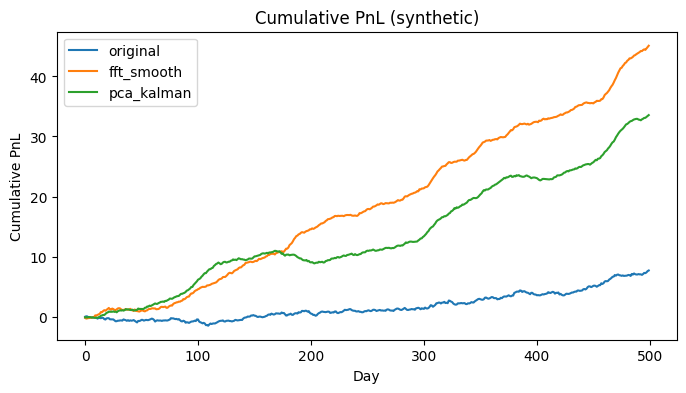

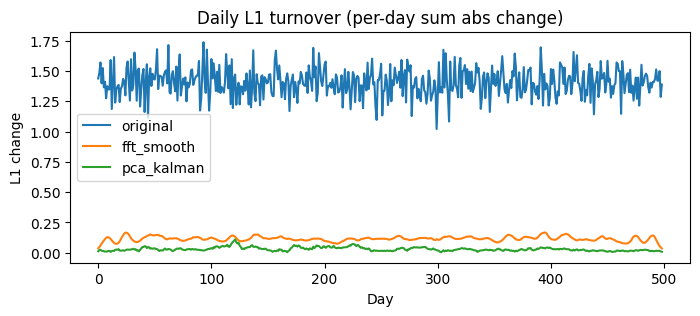

In [4]:
# Creating a synthetic experiment: original (high-turnover) strategy W, FFT low-pass smoothing, and PCA+Kalman smoothing.
# We'll compute Sharpe and turnover before/after, and plot results.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Seed
np.random.seed(42)

# Parameters
T = 500        # trading days
N = 50         # assets
k_signal = 3   # latent factors for signal
annualize = np.sqrt(252)

# 1) Generate latent factor time-series S (T x k_signal) with some persistence
phi = 0.95
S = np.zeros((T, k_signal))
S[0] = np.random.randn(k_signal)
for t in range(1, T):
    S[t] = phi * S[t-1] + 0.1 * np.random.randn(k_signal)

# 2) Asset-level loadings for the strategy and for returns (related but not identical)
L_w = np.random.randn(N, k_signal) * 0.5   # how factors map to strategy weights
L_r = L_w + 0.2 * np.random.randn(N, k_signal)  # returns related to strategy but noisy

# 3) True low-frequency strategy (signal-driven)
W_true = S @ L_w.T            # T x N
# Make rows dollar-neutral (zero mean) and scale to L1 = 1 (per-row)
def project_rowwise(W):
    Wc = W - W.mean(axis=1, keepdims=True)
    l1 = np.sum(np.abs(Wc), axis=1, keepdims=True)
    safe = (l1 > 1e-12).squeeze()
    Wc[safe] = Wc[safe] * (1.0 / l1[safe])
    return Wc

W_true = project_rowwise(W_true)

# 4) Add high-frequency noise to create high-turnover observed strategy W_orig
hf_noise_scale = 0.6
HF = hf_noise_scale * np.random.randn(T, N) * (np.linspace(1.0, 0.5, T)[:,None])  # decaying HF amplitude
W_orig = W_true + HF
W_orig = project_rowwise(W_orig)   # normalize again

# 5) Generate returns that are driven by related factors + noise
R_factors = S @ L_r.T  # T x N expected returns component
returns_noise = 0.5 * np.random.randn(T, N)
R = R_factors + returns_noise  # daily returns (not scaled)

# 6) PnL series and Sharpe function
def pnl_and_sharpe(W, R):
    p = np.sum(W * R, axis=1)    # elementwise dot per day (since W and R same shape)
    sr = p.mean() / p.std() * annualize
    return p, sr

p_orig, sr_orig = pnl_and_sharpe(W_orig, R)

# 7) Turnover (average L1 change per day)
def avg_turnover(W):
    diffs = np.abs(W[1:] - W[:-1]).sum(axis=1)
    return diffs.mean()

turn_orig = avg_turnover(W_orig)

# --- Implement FFT low-pass smoothing (vectorized) ---
def lowpass_fft(W, cutoff_frac=0.05, taper_width=0.02, pad=True):
    T, N = W.shape
    orig_T = T
    if pad:
        pad_len = min(T,  max(10, int(0.1*T)))
        pre = W[pad_len:0:-1]
        post = W[-2:-pad_len-2:-1]
        Wp = np.vstack([pre, W, post])
    else:
        Wp = W.copy()
    Tp = Wp.shape[0]
    freqs = np.fft.rfftfreq(Tp)   # in cycles per sample, ranges [0, 0.5]
    Wf = np.fft.rfft(Wp, axis=0)

    cutoff_abs = cutoff_frac * 0.5  # cutoff_frac fraction of Nyquist (0.5)
    taper = taper_width * 0.5
    low = max(0.0, cutoff_abs - taper)
    high = min(0.5, cutoff_abs + taper)

    g = np.zeros_like(freqs)
    for i, f in enumerate(freqs):
        if f <= low:
            g[i] = 1.0
        elif f >= high:
            g[i] = 0.0
        else:
            x = (f - low) / (high - low)
            g[i] = 0.5*(1 + np.cos(np.pi*(2*x - 1)))
    Wf *= g[:, None]
    Wp_smooth = np.fft.irfft(Wf, n=Tp, axis=0)
    if pad:
        W_smooth = Wp_smooth[pad_len:pad_len+orig_T]
    else:
        W_smooth = Wp_smooth[:orig_T]
    W_smooth = np.real(W_smooth)
    return W_smooth

# apply FFT smoothing and project back to constraints
cutoff = 0.06
W_fft = lowpass_fft(W_orig, cutoff_frac=cutoff, taper_width=0.02, pad=True)
W_fft = project_rowwise(W_fft)
p_fft, sr_fft = pnl_and_sharpe(W_fft, R)
turn_fft = avg_turnover(W_fft)

# --- PCA + Kalman smoothing on factor time-series ---
def compute_pca_factors(W, k):
    U, s, Vt = np.linalg.svd(W, full_matrices=False)
    U_k = U[:, :k]
    s_k = s[:k]
    Vt_k = Vt[:k, :]
    A = U_k * s_k[None, :]
    L = Vt_k.T
    return A, L

def kalman_smoother(F, Q, H, R, Y, x0=None, P0=None):
    T, kobs = Y.shape
    k = F.shape[0]
    if x0 is None:
        x0 = np.zeros(k)
    if P0 is None:
        P0 = np.eye(k) * 1e-6

    x_pred = np.zeros((T, k))
    P_pred = np.zeros((T, k, k))
    x_filt = np.zeros((T, k))
    P_filt = np.zeros((T, k, k))

    x_prev = x0.copy()
    P_prev = P0.copy()

    for t in range(T):
        x_pr = F @ x_prev
        P_pr = F @ P_prev @ F.T + Q
        y = Y[t]
        S = H @ P_pr @ H.T + R
        K = P_pr @ H.T @ np.linalg.inv(S)
        innov = y - (H @ x_pr)
        x_upd = x_pr + K @ innov
        P_upd = (np.eye(k) - K @ H) @ P_pr

        x_pred[t] = x_pr
        P_pred[t] = P_pr
        x_filt[t] = x_upd
        P_filt[t] = P_upd

        x_prev = x_upd
        P_prev = P_upd

    Xs = np.zeros_like(x_filt)
    Ps = np.zeros_like(P_filt)
    Xs[-1] = x_filt[-1]
    Ps[-1] = P_filt[-1]
    for t in range(T-2, -1, -1):
        P_pr_next = P_pred[t+1]
        J = P_filt[t] @ F.T @ np.linalg.inv(P_pr_next)
        Xs[t] = x_filt[t] + J @ (Xs[t+1] - x_pred[t+1])
        Ps[t] = P_filt[t] + J @ (Ps[t+1] - P_pr_next) @ J.T

    return Xs, Ps

def pca_kalman_smooth(W, k=5, proc_var=1e-4, obs_var=1e-2):
    A, L = compute_pca_factors(W, k)
    Y = A.copy()
    F = np.eye(k)
    H = np.eye(k)
    Q = np.eye(k) * proc_var
    Rk = np.eye(k) * obs_var
    x0 = Y[0].copy()
    P0 = np.eye(k) * 1.0
    Xs, Ps = kalman_smoother(F, Q, H, Rk, Y, x0=x0, P0=P0)
    W_smooth = Xs @ L.T
    return W_smooth, Xs, L

k = 5
W_pca_kalman, factors_smoothed, L = pca_kalman_smooth(W_orig, k=k, proc_var=1e-5, obs_var=1e-2)
W_pca_kalman = project_rowwise(W_pca_kalman)
p_kalman, sr_kalman = pnl_and_sharpe(W_pca_kalman, R)
turn_kalman = avg_turnover(W_pca_kalman)

# Summarize metrics
metrics = pd.DataFrame({
    "method": ["original", f"fft_cutoff_{cutoff}", f"pca_kalman_k{k}"],
    "sharpe": [sr_orig, sr_fft, sr_kalman],
    "avg_turnover": [turn_orig, turn_fft, turn_kalman]
})
metrics

# Plots: cumulative PnL for each method and turnover time series
p_fft_cum = np.cumsum(p_fft)
p_kalman_cum = np.cumsum(p_kalman)
p_orig_cum = np.cumsum(p_orig)

fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(p_orig_cum)
ax1.plot(p_fft_cum)
ax1.plot(p_kalman_cum)
ax1.set_title("Cumulative PnL (synthetic)")
ax1.set_xlabel("Day")
ax1.set_ylabel("Cumulative PnL")
ax1.legend(["original", "fft_smooth", "pca_kalman"])

# Turnover time series
turn_ts_orig = np.abs(W_orig[1:] - W_orig[:-1]).sum(axis=1)
turn_ts_fft = np.abs(W_fft[1:] - W_fft[:-1]).sum(axis=1)
turn_ts_kal = np.abs(W_pca_kalman[1:] - W_pca_kalman[:-1]).sum(axis=1)

fig2, ax2 = plt.subplots(figsize=(8,3))
ax2.plot(turn_ts_orig)
ax2.plot(turn_ts_fft)
ax2.plot(turn_ts_kal)
ax2.set_title("Daily L1 turnover (per-day sum abs change)")
ax2.set_xlabel("Day")
ax2.set_ylabel("L1 change")
ax2.legend(["original", "fft_smooth", "pca_kalman"])

plt.show()
